In [5]:
%cd ~/repo/protein-transfer

/home/t-fli/repo/protein-transfer


In [6]:
%load_ext blackcellmagic

The blackcellmagic extension is already loaded. To reload it, use:
  %reload_ext blackcellmagic


In [3]:
import esm

In [7]:
esm.ProteinBertModel

esm.model.esm1.ProteinBertModel

In [7]:
import torch

# Load ESM-1b model
original_model, alphabet = torch.hub.load(
            "facebookresearch/esm:main", model="esm1b_t33_650M_UR50S"
        )
batch_converter = alphabet.get_batch_converter()
data = [
    ("protein1", "MKTVRQERLKSIVRILERSKEPVSGAQLAEELSVSRQVIVQDIAYLRSLGYNIVATPRGYVLAGG")
]
batch_labels, batch_strs, batch_tokens = batch_converter(data)

original_model.eval()
with torch.no_grad():
    original_results = original_model(batch_tokens, repr_layers=[6], return_contacts=False)
original_reps = original_results["representations"][6].numpy().mean(axis=1).flatten()

Using cache found in /home/t-fli/.cache/torch/hub/facebookresearch_esm_main


In [4]:
from torch.nn.init import xavier_uniform_, xavier_normal_, zeros_, ones_

In [5]:
from scr.params.sys import DEVICE

In [8]:
"""
For esm1b, n = 0, ..., 32

ProteinBertModel(
  (embed_tokens): Embedding(33, 1280, padding_idx=1)
  (layers): ModuleList(
    (n): TransformerLayer(
      (self_attn): MultiheadAttention(
        (k_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (v_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (q_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (out_proj): Linear(in_features=1280, out_features=1280, bias=True)
      )
      (self_attn_layer_norm): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
      (fc1): Linear(in_features=1280, out_features=5120, bias=True)
      (fc2): Linear(in_features=5120, out_features=1280, bias=True)
      (final_layer_norm): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
    )
  )
  (contact_head): ContactPredictionHead(
    (regression): Linear(in_features=660, out_features=1, bias=True)
    (activation): Sigmoid()
  )
  (embed_positions): LearnedPositionalEmbedding(1026, 1280, padding_idx=1)
  (emb_layer_norm_before): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
  (emb_layer_norm_after): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
  (lm_head): RobertaLMHead(
    (dense): Linear(in_features=1280, out_features=1280, bias=True)
    (layer_norm): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
  )
)

More specifically:

embed_tokens.weight: dim 2
layers.n.self_attn.k_proj.weight: dim 2
layers.n.self_attn.k_proj.bias: dim 1
layers.n.self_attn.v_proj.weight: dim 2
layers.n.self_attn.v_proj.bias: dim 1
layers.n.self_attn.q_proj.weight: dim 2
layers.n.self_attn.q_proj.bias: dim 1
layers.n.self_attn.out_proj.weight: dim 2
layers.n.self_attn.out_proj.bias: dim 1
layers.n.self_attn_layer_norm.weight: dim 1
layers.n.self_attn_layer_norm.bias: dim 1
layers.n.fc1.weight: dim 2
layers.n.fc1.bias: dim 1
layers.n.fc2.weight: dim 2
layers.n.fc2.bias: dim 1
layers.n.final_layer_norm.weight: dim 1
layers.n.final_layer_norm.bias: dim 1
contact_head.regression.weight: dim 2
contact_head.regression.bias: dim 1
embed_positions.weight: dim 2
emb_layer_norm_before.weight: dim 1
emb_layer_norm_before.bias: dim 1
emb_layer_norm_after.weight: dim 1
emb_layer_norm_after.bias: dim 1
lm_head.weight: dim 2
lm_head.bias: dim 1
lm_head.dense.weight: dim 2
lm_head.dense.bias: dim 1
lm_head.layer_norm.weight: dim 1
lm_head.layer_norm.bias: dim 1

To reinit, follow `ProteinBertModel` class in
https://github.com/facebookresearch/esm/blob/main/esm/model/esm1.py:
https://github.com/facebookresearch/esm/blob/839c5b82c6cd9e18baa7a88dcbed3bd4b6d48e47/esm/model/esm1.py#L22

Where for `TransformerLayer` class,
`add_bias_kv=(self.model_version != "ESM-1b")` would be `False`,
and `use_esm1b_layer_norm=(self.model_version == "ESM-1b")` would be `True`

Follow `TransformerLayer` class in 
https://github.com/facebookresearch/esm/blob/main/esm/modules.py:
https://github.com/facebookresearch/esm/blob/839c5b82c6cd9e18baa7a88dcbed3bd4b6d48e47/esm/modules.py#L84

`MultiheadAttention` class in
https://github.com/facebookresearch/esm/blob/main/esm/multihead_attention.py
https://github.com/facebookresearch/esm/blob/839c5b82c6cd9e18baa7a88dcbed3bd4b6d48e47/esm/multihead_attention.py#L68

Where
    def _init_submodules(self, add_bias_kv, use_esm1b_layer_norm):
        BertLayerNorm = ESM1bLayerNorm if use_esm1b_layer_norm else ESM1LayerNorm

        self.self_attn = MultiheadAttention(
            self.embed_dim,
            self.attention_heads,
            add_bias_kv=add_bias_kv,
            add_zero_attn=False,
            use_rotary_embeddings=self.use_rotary_embeddings,
        )
        self.self_attn_layer_norm = BertLayerNorm(self.embed_dim)

        self.fc1 = nn.Linear(self.embed_dim, self.ffn_embed_dim)
        self.fc2 = nn.Linear(self.ffn_embed_dim, self.embed_dim)

        self.final_layer_norm = BertLayerNorm(self.embed_dim)

Follow ``
"""

for k, p in original_model.state_dict().items():
    print(f"{k}: dim {p.dim()}")
    if "emb_layer_norm_before" in k:
      print(p)

embed_tokens.weight: dim 2
layers.0.self_attn.k_proj.weight: dim 2
layers.0.self_attn.k_proj.bias: dim 1
layers.0.self_attn.v_proj.weight: dim 2
layers.0.self_attn.v_proj.bias: dim 1
layers.0.self_attn.q_proj.weight: dim 2
layers.0.self_attn.q_proj.bias: dim 1
layers.0.self_attn.out_proj.weight: dim 2
layers.0.self_attn.out_proj.bias: dim 1
layers.0.self_attn_layer_norm.weight: dim 1
layers.0.self_attn_layer_norm.bias: dim 1
layers.0.fc1.weight: dim 2
layers.0.fc1.bias: dim 1
layers.0.fc2.weight: dim 2
layers.0.fc2.bias: dim 1
layers.0.final_layer_norm.weight: dim 1
layers.0.final_layer_norm.bias: dim 1
layers.1.self_attn.k_proj.weight: dim 2
layers.1.self_attn.k_proj.bias: dim 1
layers.1.self_attn.v_proj.weight: dim 2
layers.1.self_attn.v_proj.bias: dim 1
layers.1.self_attn.q_proj.weight: dim 2
layers.1.self_attn.q_proj.bias: dim 1
layers.1.self_attn.out_proj.weight: dim 2
layers.1.self_attn.out_proj.bias: dim 1
layers.1.self_attn_layer_norm.weight: dim 1
layers.1.self_attn_layer_norm

In [22]:
import copy

def reset_parameters(model):
    """Initiate parameters in the transformer model."""

    for k, p in model.state_dict().items():
        print(f"{k}: dim {p.dim()}")
        if "layer" in k:
            if p.dim() > 1:
                xavier_uniform_(p)
            else:
                if "bias" in k:
                    zeros_(p)
                elif "weight" in k:
                    ones_(p)
        elif "embed_positions" in k:
            print(p)


    """for p in model.parameters():
        
        if p.dim() == 1:
            p_pre = p
        # if p.dim() > 1:
            p_post = xavier_uniform_(p)
            print(p_pre == p_post)"""
    
    return model

def resample_parameters(model):

    for p in model.parameters():
        if p.dim() > 1:
            print(p)
            xavier_normal_(p)
    
    return model

In [11]:
import matplotlib.pyplot as plt

In [26]:
from torch.nn import Parameter

In [27]:
Parameter(torch.Tensor(1, 1, 10))

Parameter containing:
tensor([[[-2.9612e-08,  4.5560e-41,  2.6462e+01,  3.0697e-41,  1.4013e-45,
           0.0000e+00,  0.0000e+00,  2.3694e-38,  6.7262e-44,  0.0000e+00]]],
       requires_grad=True)

In [29]:
zeros_(Parameter(torch.Tensor(1, 1, 10)))

Parameter containing:
tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], requires_grad=True)

In [23]:
model = copy.deepcopy(original_model).to(DEVICE)
model = reset_parameters(model)
model.eval()  # disables dropout for deterministic results

# Prepare data (first 2 sequences from ESMStructuralSplitDataset superfamily / 4)

# Extract per-residue representations (on CPU)
with torch.no_grad():
    results = model(batch_tokens, repr_layers=[6], return_contacts=False)
reset_reps = results["representations"][6].numpy().mean(axis=1).flatten()

embed_tokens.weight: dim 2
layers.0.self_attn.k_proj.weight: dim 2
layers.0.self_attn.k_proj.bias: dim 1
layers.0.self_attn.v_proj.weight: dim 2
layers.0.self_attn.v_proj.bias: dim 1
layers.0.self_attn.q_proj.weight: dim 2
layers.0.self_attn.q_proj.bias: dim 1
layers.0.self_attn.out_proj.weight: dim 2
layers.0.self_attn.out_proj.bias: dim 1
layers.0.self_attn_layer_norm.weight: dim 1
layers.0.self_attn_layer_norm.bias: dim 1
layers.0.fc1.weight: dim 2
layers.0.fc1.bias: dim 1
layers.0.fc2.weight: dim 2
layers.0.fc2.bias: dim 1
layers.0.final_layer_norm.weight: dim 1
layers.0.final_layer_norm.bias: dim 1
layers.1.self_attn.k_proj.weight: dim 2
layers.1.self_attn.k_proj.bias: dim 1
layers.1.self_attn.v_proj.weight: dim 2
layers.1.self_attn.v_proj.bias: dim 1
layers.1.self_attn.q_proj.weight: dim 2
layers.1.self_attn.q_proj.bias: dim 1
layers.1.self_attn.out_proj.weight: dim 2
layers.1.self_attn.out_proj.bias: dim 1
layers.1.self_attn_layer_norm.weight: dim 1
layers.1.self_attn_layer_norm

In [8]:
model = copy.deepcopy(original_model).to(DEVICE)
model = resample_parameters(model)
model.eval()  # disables dropout for deterministic results

# Prepare data (first 2 sequences from ESMStructuralSplitDataset superfamily / 4)

# Extract per-residue representations (on CPU)
with torch.no_grad():
    results = model(batch_tokens, repr_layers=[6], return_contacts=False)
resample_reps = results["representations"][6].numpy().mean(axis=1).flatten()

Parameter containing:
tensor([[-0.0413, -0.2133, -0.0548,  ...,  0.0196, -0.0637, -0.1171],
        [-0.0615, -0.1991, -0.0793,  ..., -0.0236, -0.0546, -0.0750],
        [-0.0581, -0.1780, -0.0551,  ...,  0.0043, -0.0647, -0.1356],
        ...,
        [-0.0487, -0.1576, -0.0444,  ..., -0.0144,  0.0009, -0.0975],
        [-0.0615, -0.2097, -0.0668,  ..., -0.0242, -0.0476, -0.1399],
        [-0.0673, -0.1897, -0.0970,  ..., -0.0082, -0.0414, -0.0869]],
       requires_grad=True)
Parameter containing:
tensor([[-0.0030, -0.0021, -0.0090,  ..., -0.0151,  0.0036, -0.0182],
        [ 0.0142,  0.0201, -0.0359,  ...,  0.0030,  0.0182,  0.0063],
        [ 0.0021, -0.0257,  0.0011,  ..., -0.0227, -0.0143,  0.0031],
        ...,
        [ 0.0079,  0.0108,  0.0085,  ..., -0.0959, -0.0330, -0.0087],
        [-0.0008,  0.0035,  0.0009,  ...,  0.0263, -0.0150, -0.0114],
        [ 0.0109,  0.0342,  0.0091,  ...,  0.0195,  0.0143,  0.0061]],
       requires_grad=True)
Parameter containing:
tensor([[[ 2

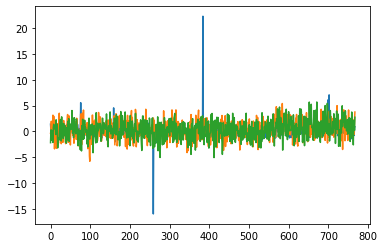

In [12]:
plt.plot(original_reps)
plt.plot(reset_reps)
plt.plot(resample_reps)

In [13]:
from sequence_models.pretrained import load_model_and_alphabet

original_model, collater = load_model_and_alphabet('carp_600k')

seqs = [['MKTVRQERLKSIVRILERSKEPVSGAQLAEELSVSRQVIVQDIAYLRSLGYNIVATPRGYVLAGG']]
x = collater(seqs)[0]  # (n, max_len)
original_rep = original_model(x).detach().numpy().mean(axis=1)  # (n, max_len, d_model)
original_rep.shape

(1, 128)

In [14]:
import copy

In [15]:
model = copy.deepcopy(original_model).to(DEVICE)
model = reset_parameters(model)
model.eval()  # disables dropout for deterministic results

reset_reps = model(x).detach().numpy().mean(axis=1)
reset_reps.shape

(1, 128)

In [16]:
model = copy.deepcopy(original_model).to(DEVICE)
model = resample_parameters(model)
model.eval()  # disables dropout for deterministic results

resample_reps = model(x).detach().numpy().mean(axis=1)
resample_reps.shape

(1, 128)

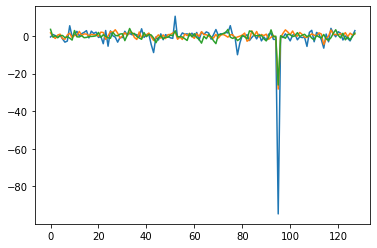

In [17]:
plt.plot(original_rep.T)
plt.plot(reset_reps.T)
plt.plot(resample_reps.T)